## HyperOpt Remote Training with Child Runs

https://github.com/hyperopt/hyperopt-sklearn/blob/master/notebooks/Demo-Iris.ipynb

In [12]:
import azureml.core
import pandas as pd
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.33.0 to work with mm-aml-dev


In [13]:
!pip install hyperopt
!pip install git+https://github.com/hyperopt/hyperopt-sklearn.git

  Cloning https://github.com/hyperopt/hyperopt-sklearn.git to /tmp/pip-req-build-ho8d_aav
  Running command git clone -q https://github.com/hyperopt/hyperopt-sklearn.git /tmp/pip-req-build-ho8d_aav
  Created wheel for hpsklearn: filename=hpsklearn-0.0.3-py3-none-any.whl size=26994 sha256=7d09652ac9c85c52c3cd503a871e0bd4b685862e249d9cd341b441322a9187af
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ugxped6/wheels/35/2d/91/ed44b48b092472e2b1abf6fc84dd8dca06c2202a4127623082
Successfully built hpsklearn


In [14]:
# define an objective function
import hyperopt

def objective(args):
    case, val = args
    if case == 'case 1':
        return val
    else:
        return val ** 2

# define a search space
from hyperopt import hp
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

# minimize the objective over the space
from hyperopt import fmin, tpe
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

print (best)
# -> {'a': 1, 'c2': 0.01420615366247227}
print (hyperopt.space_eval(space, best))
# -> ('case 2', 0.01420615366247227}

100%|██████████| 100/100 [00:00<00:00, 162.34trial/s, best loss: 0.0001511348809633245]
{'a': 1, 'c2': -0.012293692730962674}
('case 2', -0.012293692730962674)


In [15]:
from hyperopt import fmin, tpe, hp
best = fmin(fn=lambda x: x ** 2,
    space=hp.uniform('x', -10, 10),
    algo=tpe.suggest,
    max_evals=100)
print (best)

100%|██████████| 100/100 [00:00<00:00, 315.48trial/s, best loss: 0.00016027278774741188]
{'x': -0.012659888931085134}


In [16]:
import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK

def objective(x):
    return {'loss': x ** 2, 'status': STATUS_OK }

best = fmin(objective,
    space=hp.uniform('x', -10, 10),
    algo=tpe.suggest,
    max_evals=100)

print (best)

100%|██████████| 100/100 [00:00<00:00, 327.67trial/s, best loss: 4.564849731573872e-06]
{'x': 0.002136550896087868}


In [17]:
import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def objective(x):
    return {
        'loss': x ** 2,
        'status': STATUS_OK,
        # -- store other results like this
        'eval_time': time.time(),
        'other_stuff': {'type': None, 'value': [0, 1, 2]},
        # -- attachments are handled differently
        'attachments':
            {'time_module': pickle.dumps(time.time)}
        }
trials = Trials()
best = fmin(objective,
    space=hp.uniform('x', -10, 10),
    algo=tpe.suggest,
    max_evals=100,
    trials=trials)

print (best)

100%|██████████| 100/100 [00:00<00:00, 322.49trial/s, best loss: 0.00020932953825325023]
{'x': -0.014468225124501286}


## HyperOpt

In [ ]:
#https://github.com/hyperopt/hyperopt-sklearn/blob/master/notebooks/Demo-Iris.ipynb

Best preprocessing pipeline:
Normalizer(norm='l1')


Best classifier:
 KNeighborsClassifier(metric='euclidean', n_jobs=1, n_neighbors=2)


Prediction accuracy in generalization is 97.8%


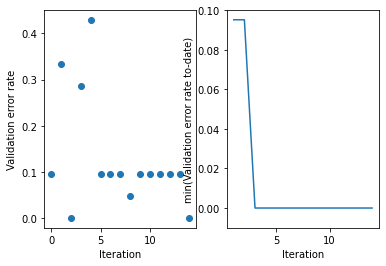

In [26]:

from azureml.core import Experiment, Run, Model, Dataset
import os
os.environ['OMP_NUM_THREADS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import hpsklearn
import hpsklearn.demo_support
import hyperopt.tpe
import pandas as pd
import numpy as np
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display


directory = 'outputs'
if not os.path.exists(directory):
    os.mkdir(directory)
        
def scatter_error_vs_time(estimator, ax):
    losses = estimator.trials.losses()
    ax.set_ylabel('Validation error rate')
    ax.set_xlabel('Iteration')
    ax.scatter(list(range(len(losses))), losses)


def plot_minvalid_vs_time(estimator, ax, ylim=None):
    losses = estimator.trials.losses()
    ts = list(range(1, len(losses)))
    mins = [np.min(losses[:ii]) for ii in ts]
    ax.set_ylabel('min(Validation error rate to-date)')
    ax.set_xlabel('Iteration')
    if ylim:
        ax.set_ylim(*ylim)
    ax.plot(ts, mins)


class MyplotHelper(object):

    def __init__(self, estimator, mintodate_ylim):
        self.estimator = estimator
        self.fig, self.axs = plt.subplots(1, 2)
        self.post_iter_wait = .5
        self.mintodate_ylim = mintodate_ylim

    def post_iter(self):
        self.axs[0].clear()
        self.axs[1].clear()
        scatter_error_vs_time(self.estimator, self.axs[0])
        plot_minvalid_vs_time(self.estimator, self.axs[1],
                              ylim=self.mintodate_ylim)
        display.clear_output()
        print('saving image')
        self.fig.savefig('./outputs/output.png')
        #display.display(self.fig)
        time.sleep(self.post_iter_wait)

    def post_loop(self):
        self.fig.savefig('./outputs/outputfinal.png')
        display.clear_output()

experiment = Experiment(workspace=ws, name='tester')
run = experiment.start_logging()

print('creating estimator')
estimator = hpsklearn.HyperoptEstimator(
    preprocessing=hpsklearn.components.any_preprocessing('pp'),
    classifier=hpsklearn.components.any_classifier('clf'),
    algo=hyperopt.tpe.suggest,
    trial_timeout=15.0, # seconds
    max_evals=15,
    )

print('loading dataset')
# PREPARE TRAINING AND TEST DATA
iris = load_iris()
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['species_name'] = pd.Categorical.from_codes(iris.target, iris.target_names)
y = df_iris['species_name']
X = df_iris.drop(['species_name'], axis=1)

# TRAIN AND TEST DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Demo version of estimator.fit()
fit_iterator = estimator.fit_iter(X_train,y_train)
fit_iterator.__next__()
plot_helper = MyplotHelper(estimator,
                                                mintodate_ylim=(-.01, .10))
while len(estimator.trials.trials) < estimator.max_evals:
    child = run.child_run()
    child.log(name= 'max evals', value = estimator.max_evals)
    child.log(name ='run', value = estimator.max_evals)
    fit_iterator.send(1) # -- try one more model
    
    losses = estimator.trials.losses()
    index = len(losses)
    
    child.log(name= 'index', value = index)
    
    plot_helper.post_iter()

    
    child.upload_file(name = './outputs/output.png', path_or_stream = './outputs/output.png')
    child.complete()
    
plot_helper.post_loop()

# -- Model selection was done on a subset of the training data.
# -- Now that we've picked a model, train on all training data.
estimator.retrain_best_model_on_full_data(X_train, y_train)

print('Best preprocessing pipeline:')
for pp in estimator._best_preprocs:
    print(pp)
    run.log(name = 'best prepossing', value = pp)
print('\n')
print('Best classifier:\n', estimator._best_learner)

run.log(name = 'best classifer', value = estimator._best_learner)
test_predictions = estimator.predict(X_test)
acc_in_percent = 100 * np.mean(test_predictions == y_test)
print('\n')
print('Prediction accuracy in generalization is %.1f%%' % acc_in_percent)
run.log(name = 'accuracy', value = acc_in_percent)

run.complete()